### RankNet-makedb-laptime

build laptime dataset from raw log files

base: 18./laptime_rank_timediff_dataset

create laptime dataset only, no gluonts.

+ add lap2nextpit as target, this is as the same as a stacked lstm model when set prediction_length=1
+ add lap_instint to dynamic features(pitage)
+ add support for historical data, indy500 for different years
+ add track and lap status as target, preparing for StatusModel with deepAR

this notebook focuses on create the training set, while laptime2rank-evaluate will have testset codes specified for rank calculation

+ add new features, caution_laps_instint,lap_instint

Build a time series dataset across all the oval races, including laptime, rank. When this dataset aims to be used in forecasting, covariates of the racing status can not be included, such as track_status and lap_status. However, they can be used in oracle test to tell the upper bound of performance of the predictor.

Change to a new dataset format that following telemetry dataset.

raw:
+  [(eventid, carids: carno -> rowid, datalist)]

datalist := [datalist_entry] in shape of #car_number

datalist_entry := [[laptime, rank, track_status, lap_status]], in shape of #totallaps x #featureCnt (padded by nan)

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load Data

In [ ]:
import os
os.getcwd()

In [ ]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    #uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
    #                  "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
    #                  "last_pitted_lap","start_position","laps_led"], axis=1)
    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", 
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
        
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    #df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    #df = uni_ds[['car_number','completed_laps','rank',
    #             'rank_diff','time_diff',"current_status", "track_status", "lap_status",'elapsed_time']]
    
    df = uni_ds[['car_number','completed_laps','time_diff','rank','track_status', 'lap_status','elapsed_time']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [ ]:
def load_data(event, year=0):
    #inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    if year>0:
        inputfile = '../data/final/C_'+ event +'-' + year + '.csv'
    else:
        inputfile = '../data/final/C_'+ event +'.csv'
    
    #outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

### overall view of laptime scatter plots



In [ ]:
def get_cardata(curcarno, ycol='time_diff'):
    car = acldata[acldata['car_number']==curcarno]
    #print(car['time_diff'].describe())
    
    cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
    colid={key:idx for idx, key in enumerate(cols)}

    cardata = rankdata[rankdata['car_number'] == curcarno]

    carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
        ['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']].values]
    
    x = car['completed_laps'][1:].values
    y = car[ycol][1:].values

    pits=[]
    yellowflags=[]
    lastflag = 'x'
    for row in carstatus:
        lap = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            pits.append(lap)

        if row[colid['track_status']]=='Y':
            if lastflag != 'Y':       
                #start
                yellowflags.append(lap)
        else:
            if lastflag == 'Y':       
                #end
                yellowflags.append(lap)        
        lastflag = row[colid['track_status']]

    #pit lap
    pits = np.array(pits)
    #start, end lap
    #
    yellowflags = np.array(yellowflags)
    if (yellowflags.shape[0] % 2)==1:
        print('crash?:carno=', curcarno)
        yellowflags = []
    else:
        yellowflags = np.array(yellowflags).reshape((-1,2))    
    
    return car, x, y, pits, yellowflags

### bulid the dataset

In [ ]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def get_lap2nextpit(lap_status, maxlap=200):
    """
    input:
        lapstatus  ; array of 0/1 indicating pitstops for each lap, nan means incomplete race
        maxlap     ; the max lap number of the race
    output:
        lap2nextpit ; array of the lap gap to the next pit for each lap
    
    """
    
    #pitstops = np.where(lap_status==1)[0]
                    
    pitstops = list(np.where(lap_status==1)[0])
    #if not len(lap_status) < maxlap:
    nans, x= nan_helper(lap_status)
    nan_count = np.sum(nans)      
    if nan_count == 0:
        #complete cars
        # the last stint, to the end
        pitstops.append(maxlap)
    
    lap2nextpit = np.zeros_like(lap_status)
    lap2nextpit[:] = np.nan
    
    #guard
    if len(pitstops)==0:
        return lap2nextpit
    
    idx = 0
    for lap in range(len(lap_status)):
        if lap < pitstops[idx]:
            lap2nextpit[lap] = pitstops[idx] - lap
        else:
            idx += 1
            if idx < len(pitstops):
                lap2nextpit[lap] = pitstops[idx] - lap
            else:
                break
            
    return lap2nextpit


In [ ]:
def get_lapdata(acldata):
    """
    input:
        acldata['car_number','completed_laps','time_diff','rank','track_status', 'lap_status','elapsed_time']
    
        timediff: [car_number, completed_laps] -> elapsed time diff to leader
    output:
        lapdata = acldata[['car_number','completed_laps',
                           'time_diff','rank','track_status', 'lap_status','time_behind']].to_numpy()
    """
    COL_COMPLETED_LAPS = 1
    COL_ELAPSED_TIME = 6
    
    maxlap = np.max(acldata['completed_laps'].values)
    #'car_number','completed_laps','time_diff','rank','track_status', 'lap_status','time_behind'
    time_behind = []
    
    for lap in range(1, maxlap+1):
        this_lap = acldata[acldata['completed_laps']==lap][
            ['car_number','completed_laps','time_diff','rank',
             'track_status', 'lap_status','elapsed_time']].values
        
        min_elapsed_time = np.nanmin(this_lap[:,COL_ELAPSED_TIME].astype(np.float))
        #print(f'lap:{lap}, min_elapsed_time:{min_elapsed_time}')
        
        for row in this_lap:
            car_number = int(row[0])
            time_diff = row[2]
            rank = row[3]
            track_status = row[4]
            lap_status = row[5]
            
            timebehind = float(row[COL_ELAPSED_TIME]) - min_elapsed_time
            #
            time_behind.append([car_number, lap, time_diff,rank,track_status, lap_status,
                                timebehind, float(row[COL_ELAPSED_TIME])])
    
    #return
    lapdata = np.array(time_behind)
    return lapdata



# features: laptime, rank, track_status, lap_status, timediff
LAPTIME = 0
RANK = 1
TRACK_STATUS = 2
LAP_STATUS = 3
TIME_BEHIND = 4
CAUTION_LAPS_INSTINT = 5 
LAPS_INSTINT = 6
ELAPSED_TIME = 7
LAP2NEXTPIT = 8

_featureCnt = 9
        
def get_laptime_dataset(stagedata, inlap_status = 0):
    """
    #add caution_laps_instint, laps_instint
    
    input: (alldata, rankdata, acldata, flagdata)
    output: laptime & rank data
    
    [(
    eventid,
    carids : rowid -> carno,
    datalist: #car_number x features x #totallaps (padded by Nan)
        entry: [[laptime, rank, track_status, lap_status,
                caution_laps_instint, laps_instint]]
    )]
    """
    laptime_data = []
    for event in stagedata.keys():
        
        print(f'start event: {event}')
        
        laptime_rec = []
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)
        


        #carnumber -> carid
        carids={key:idx for idx, key in enumerate(carlist)}
        decode_carids={idx:key for idx, key in enumerate(carlist)}

        #init
        lap_instint = {carids[x]:0 for x in carlist}
        caution_instint = {carids[x]:0 for x in carlist}        
        
        #array: car_number x lap
        #laptime = np.zeros((totalcars, totallaps-1))
        #rank = np.zeros((totalcars, totallaps-1))
        laptime = np.empty((totalcars, totallaps-1))
        rank = np.empty((totalcars, totallaps-1))
        laptime[:] = np.NaN
        rank[:] = np.NaN
        

        datalist = np.empty((totalcars, _featureCnt, totallaps-1))
        datalist[:] = np.NaN
        
        #lapdata = acldata[['car_number','completed_laps',
        #                   'time_diff','rank','track_status', 'lap_status','elapsed_time']].to_numpy()
        
        #'car_number','completed_laps','time_diff','rank','track_status', 'lap_status','time_behind'
        lapdata = get_lapdata(acldata)
        
        
        for row in lapdata:
            #completed_laps
            if int(row[1]) == 0:
                continue
                
            #add to data array
            car_number = carids[int(row[0])]
            completed_laps = int(row[1])-1
            time_diff = float(row[2])
            rank = int(row[3])
            track_status = 1 if row[4]=='Y' else 0
            lap_status = 1 if row[5]=='P' else 0
            time_behind = float(row[6])
            
            datalist[car_number, LAPTIME, completed_laps] = time_diff
            datalist[car_number, RANK, completed_laps] = rank
            datalist[car_number, TRACK_STATUS, completed_laps] = track_status
            datalist[car_number, LAP_STATUS, completed_laps] = lap_status
            datalist[car_number, TIME_BEHIND, completed_laps] = time_behind

            datalist[car_number, ELAPSED_TIME, completed_laps] = float(row[7])

            
            #stint status
            if track_status == 1:
                caution_instint[car_number] += 1
            lap_instint[car_number] += 1
            if lap_status == 1:
                #new stint
                lap_instint[car_number] = 0
                caution_instint[car_number] = 0
                
                # add inlap feature into lap_Status
                # set the previous lap to inlap status
                
                # what does it mean?
                
                if (inlap_status!=0):
                    if inlap_status == 1:
                        # set the previous lap of 'P'
                        if completed_laps > 0:
                            #datalist[car_number, LAP_STATUS, completed_laps-1] = INLAP_STATUS
                            datalist[car_number, LAP_STATUS, completed_laps-1] = 1
                    else:
                        # set the next lap of 'P'
                        if completed_laps +1 < totallaps:
                            #datalist[car_number, LAP_STATUS, completed_laps-1] = INLAP_STATUS
                            datalist[car_number, LAP_STATUS, completed_laps + 1] = 1
                
            
            datalist[car_number, LAPS_INSTINT, completed_laps] = lap_instint[car_number]
            datalist[car_number, CAUTION_LAPS_INSTINT, completed_laps] = caution_instint[car_number]
                

                
        #update lap2nextpit in datalist
        for caridx in range(datalist.shape[0]):
            lap_status = datalist[caridx, LAP_STATUS, :]
            #pit status
            lap2nextpit = get_lap2nextpit(lap_status)
            datalist[caridx, LAP2NEXTPIT, :] = lap2nextpit        
                
        #add one record
        laptime_data.append([eventid, decode_carids, datalist])
        # push this event into stage dataframe
        print('event=%s, records=%s'%(event, datalist.shape))
        
    
    return laptime_data

### load data

In [ ]:
stagedata = {}
global_carids = {}
traindata = None
cur_carid = 0

#inlap status = 
# 0 , no inlap
# 1 , set previous lap
# 2 , set the next lap
_inlap_status = 2

years = ['2013','2014','2015','2016','2017','2018','2019']
#years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}

dbid = f'Indy500_{years[0]}_{years[-1]}_v{_featureCnt}_p{_inlap_status}'

for event in events:
    #dataid = f'{event}-{year}'
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event)

    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))

    #build the carid map
    for car in carlist:
        if car not in global_carids:
            global_carids[car] = cur_carid
            cur_carid += 1
    


In [ ]:
laptime_data = get_laptime_dataset(stagedata,inlap_status = _inlap_status)

In [10]:
import pickle
#stintdf.to_csv('laptime-%s.csv'%year)
savefile = f'laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
print(savefile)
with open(savefile, 'wb') as f:
    #pack [global_carids, laptime_data]
    savedata = [global_carids, laptime_data]
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle


### test

In [11]:
sys.exit(0)

SystemExit: 0

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
lapstatusA = laptime_data[-1][2][1,3,:]
#lapstatusA = laptime_data[-1][2][0,3,:]
lapstatusA

In [ ]:
lap2nextpit = laptime_data[-1][2][1,8,:]
#lap2nextpit = laptime_data[-1][2][0,8,:]
lap2nextpit

In [ ]:
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [ ]:
def test_a(a, bitflag):
    return (a & bitflag) ==  bitflag

test_a(5, 4)


In [ ]:
mat = np.random.randint(5, size=(10,2, 5)).astype(np.float)
mat[2,1,0] = np.nan
_idx = np.array([0,1,2,8])
selmat = mat[_idx]
selmat[:,1,:]

In [ ]:
mask = np.isnan(selmat[:,1,:])
mask

In [ ]:
true_rank.shape

In [ ]:
idx = np.argsort(selmat[:,1,:], axis=0)
true_rank = np.argsort(idx, axis=0).astype(np.float)
true_rank[mask] = np.nan
true_rank

In [ ]:
selmat[:,1,:] = true_rank
selmat

In [ ]:
mat[_idx]

In [ ]:
mat[_idx] = selmat

In [ ]:
mat[_idx]

In [ ]:
freq, prediction_length, cardinality = 0,0,0

def load_dataset(inputfile):
    global freq, prediction_length, cardinality

    with open(inputfile, 'rb') as f:
        # have to specify it.
        freq, prediction_length, cardinality,train_ds, test_ds = pickle.load(f, encoding='latin1')
    
    print(f"number of cars: {cardinality}")
    
    return train_ds, test_ds

train_ds, test_ds = load_dataset('rank-oracle-noip-eid-all-all-f1min-t30-rIndy500-gluonts-indy-2018.pickle')

In [ ]:
ds_iter =  iter(test_ds)
rec = next(ds_iter)
rec

In [ ]:
def debug_get_ranklist(train_ds):
    ds_iter =  iter(train_ds)
    ranklist = []
    for idx in range(len(train_ds)):
        rec = next(ds_iter)

        if rec['feat_static_cat'][1] == 0:
            ranklist.append(rec['target'][0])

    return np.array(sorted(ranklist))

In [ ]:
len(ranklist)

In [ ]:
rank_train, rank_ds = get_testds(True)

In [ ]:
rawrank_train, rawrank_ds = get_testds(False)

In [ ]:
debug_get_ranklist(rank_train)

In [ ]:
debug_get_ranklist(rawrank_train)

In [ ]:
debug_get_ranklist(train_ds)

In [ ]:
 #alldata, rankdata, acldata, flagdata = stagedata['Indy500-2011']

In [ ]:
set(acldata.car_number.values)

In [ ]:
acldata

In [ ]:
acldata[acldata['completed_laps']==187]

In [ ]:
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==186].car_number.values))))
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==187].car_number.values))))
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==188].car_number.values))))
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==189].car_number.values))))


In [ ]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2014']

In [ ]:
kannan = rankdata[rankdata['car_number']==10]
kannan[(kannan['completed_laps'] > 60) & (kannan['completed_laps']<70)]

In [ ]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2013']
rankdata[(rankdata['car_number']==16) & (rankdata['completed_laps']<10)]

In [ ]:
rankdata[(rankdata['car_number']==16) & (rankdata['completed_laps']>88)& (rankdata['completed_laps']<97)]

In [ ]:
car16 = acldata[acldata['car_number']==16]


In [ ]:
for idx in range(len(car16)):
    if(car16.iloc[idx].lap_status == 'P'):
        print(car16.iloc[idx].completed_laps)

In [ ]:
for idx in range(len(car16)):
    if(car16.iloc[idx].track_status == 'Y'):
        print(car16.iloc[idx].completed_laps)

In [16]:
### check the inlap
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']
car12 = acldata[acldata['car_number']==59]
for idx in range(len(car12)):
    if(car12.iloc[idx].lap_status == 'P'):
        print(car12.iloc[idx].completed_laps)

30
53
60
62
98
129
156
158
190
196


In [14]:
rankdata[(rankdata['car_number']==12)]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
2,3,12,2,0,0.2247,90.2903,T,0.0000,0,0.2247,...,0.1127,0,3,0.0000,Active,G,0,0,3,0
37,2,12,2,1,42.1485,41.9238,T,41.9238,1,0.2113,...,0.2113,0,2,41.9238,Active,G,0,0,3,0
148,2,12,2,2,83.1845,41.0360,T,41.0360,2,0.4727,...,0.4727,0,2,41.0360,Active,G,0,0,3,0
231,3,12,2,3,124.5184,41.3339,T,41.0360,2,0.9999,...,0.5951,0,3,41.0360,Active,G,0,0,3,0
311,3,12,2,4,165.6102,41.0918,T,41.0360,2,1.2514,...,0.8079,0,3,41.0360,Active,G,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,1,12,2,196,10619.6075,41.6069,T,40.3590,24,0.0000,...,0.0000,0,1,40.3590,Active,G,5,AB,3,37
18164,1,12,2,197,10660.4033,40.7958,T,40.3590,24,0.0000,...,0.0000,0,1,40.3590,Active,G,5,AB,3,38
18255,1,12,2,198,10700.9679,40.5646,T,40.3590,24,0.0000,...,0.0000,0,1,40.3590,Active,G,5,AB,3,39


In [13]:
pitlap = 32
rankdata[(rankdata['car_number']==12) & (rankdata['completed_laps']>=pitlap -2) & ((rankdata['completed_laps']<=pitlap+2))]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
2610,4,12,2,30,1243.1682,44.0387,T,40.7903,5,1.1264,...,0.4850,0,4,40.7903,Active,G,0,0,3,0
2700,2,12,2,31,1288.8561,45.6879,T,40.7903,5,1.6026,...,1.6026,0,2,40.7903,Active,G,0,0,3,0
2836,4,12,2,32,1345.0213,56.1652,P,40.7903,5,12.3354,...,2.4475,0,4,40.7903,Active,G,1,20,3,0
3094,18,12,2,33,1412.5610,67.5397,T,40.7903,5,37.0525,...,0.0355,0,12,40.7903,Active,G,1,20,3,0
3219,10,12,2,34,1454.1976,41.6366,T,40.7903,5,23.9824,...,0.4734,0,A,40.7903,Active,G,1,20,3,0


In [ ]:
pitlap = 50
rankdata[(rankdata['car_number']==12) & (rankdata['completed_laps']>=pitlap -2) & ((rankdata['completed_laps']<=pitlap+2))]

In [ ]:
pitlap = 94
rankdata[(rankdata['car_number']==12) & (rankdata['completed_laps']>=pitlap -2) & ((rankdata['completed_laps']<=pitlap+2))]

In [17]:
rankdata[(rankdata['completed_laps']==200)]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
18419,1,12,2,200,10782.6365,41.3651,T,40.3035,C7,0.0000,...,0.0000,0,1,40.3035,Active,K,5,AB,3,3B
18452,2,20,0,200,10785.7954,41.7902,T,40.2368,21,3.1589,...,3.1589,0,2,40.2368,Active,K,5,AD,1,41
18456,3,9,8,200,10787.2293,41.5713,T,40.6543,85,4.5928,...,1.4339,0,3,40.6543,Active,K,5,A0,9,0
18457,4,27,1F,200,10787.8602,41.5437,T,40.3275,B3,5.2237,...,0.6309,0,4,40.3275,Active,K,5,AE,20,1
18460,5,28,D,200,10789.3552,42.0466,T,40.4560,B4,6.7187,...,1.4950,0,5,40.4560,Active,K,5,AC,E,1
18461,6,22,1,200,10789.8722,42.2442,T,40.4933,B5,7.2357,...,0.5170,0,6,40.4933,Active,K,5,AF,2,1
18464,7,29,14,200,10790.4742,42.2352,T,40.1956,B2,7.8377,...,0.6020,0,7,40.1956,Active,K,6,B0,15,4
18466,8,1,3,200,10791.3282,41.7541,T,40.5625,AE,8.6917,...,0.8540,0,8,40.5625,Active,K,6,AA,4,3
18468,9,6,11,200,10791.9477,41.4786,T,40.5861,C6,9.3112,...,0.6195,0,9,40.5861,Active,K,7,BF,12,2


In [18]:
rankdata[(rankdata['completed_laps']==0)]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
0,1,20,0,0,0.0000,91.4880,T,0.0,0,0.0000,...,0.0000,0,1,0.0,Active,G,0,0,1,0
1,2,22,1,0,0.1120,91.0722,T,0.0,0,0.1120,...,0.1120,0,2,0.0,Active,G,0,0,2,0
2,3,12,2,0,0.2247,90.2903,T,0.0,0,0.2247,...,0.1127,0,3,0.0,Active,G,0,0,3,0
4,5,18,4,0,0.3152,89.3432,T,0.0,0,0.3152,...,0.0000,0,5,0.0,Active,G,0,0,5,0
3,4,1,3,0,0.4150,89.7686,T,0.0,0,0.4150,...,0.1903,0,4,0.0,Active,G,0,0,4,0
5,6,21,5,0,0.4757,88.2831,T,0.0,0,0.4757,...,0.1605,0,6,0.0,Active,G,0,0,6,0
6,9,9,8,0,0.9168,85.0895,T,0.0,0,0.9168,...,0.9168,0,9,0.0,Active,G,0,0,9,0
8,8,3,7,0,0.9523,85.8539,T,0.0,0,0.9523,...,0.0000,0,8,0.0,Active,G,0,0,8,0
7,7,13,6,0,0.9676,87.6776,T,0.0,0,0.9676,...,0.4919,0,7,0.0,Active,G,0,0,7,0


In [21]:
### top cars
top10 = rankdata[(rankdata['completed_laps']==200) & (rankdata['rank']<10)]
list(top10.car_number)

[12, 20, 9, 27, 28, 22, 29, 1, 6]

In [22]:
### show the data
dfx = rankdata
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5769 entries, 0 to 18498
Data columns (total 21 columns):
rank                    5769 non-null int64
car_number              5769 non-null int64
unique_id               5769 non-null object
completed_laps          5769 non-null int64
elapsed_time            5769 non-null float64
last_laptime            5769 non-null float64
lap_status              5769 non-null object
best_laptime            5769 non-null float64
best_lap                5769 non-null object
time_behind_leader      5769 non-null float64
laps_behind_leade       5769 non-null object
time_behind_prec        5769 non-null float64
laps_behind_prec        5769 non-null object
overall_rank            5769 non-null object
overall_best_laptime    5769 non-null float64
current_status          5769 non-null object
track_status            5769 non-null object
pit_stop_count          5769 non-null object
last_pitted_lap         5769 non-null object
start_position          5769 non-n

In [30]:
dfx = rankdata[['rank','car_number','completed_laps','last_laptime','time_behind_leader','lap_status','track_status']]
#dfx.drop('index')
dfx[(dfx['completed_laps']>30) & (dfx['completed_laps']<50)]

,rank,car_number,completed_laps,last_laptime,time_behind_leader,lap_status,track_status
MyIdx,,,,,,,
2673,1,1,31,44.6091,0.0000,T,G
2700,2,12,31,45.6879,1.6026,T,G
2709,3,21,31,43.3229,2.6397,T,G
2710,4,18,31,44.7068,2.8218,T,G
2715,5,9,31,42.2613,4.8894,T,G
...,...,...,...,...,...,...,...
4797,31,32,48,105.1815,1.2756,T,Y
4804,29,59,49,104.9457,3.5234,T,Y
4807,30,17,49,104.3930,3.9876,T,Y


### draw timeline

In [ ]:
### draw timeline
df12 = rankdata[rankdata['car_number']==12]
df12

In [ ]:
df12[df12['lap_status']=='P']

In [117]:
df12[df12['completed_laps'].isin([30,31,32,33,34])]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
2610,4,12,2,30,1243.1682,44.0387,T,40.7903,5,1.1264,...,0.4850,0,4,40.7903,Active,G,0,0,3,0
2700,2,12,2,31,1288.8561,45.6879,T,40.7903,5,1.6026,...,1.6026,0,2,40.7903,Active,G,0,0,3,0
2836,4,12,2,32,1345.0213,56.1652,P,40.7903,5,12.3354,...,2.4475,0,4,40.7903,Active,G,1,20,3,0
3094,18,12,2,33,1412.5610,67.5397,T,40.7903,5,37.0525,...,0.0355,0,12,40.7903,Active,G,1,20,3,0
3219,10,12,2,34,1454.1976,41.6366,T,40.7903,5,23.9824,...,0.4734,0,A,40.7903,Active,G,1,20,3,0


In [103]:
data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
pitstop = df12[['lap_status']].values
caution = df12[['track_status']].values
pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
caution = np.array([1 if x=='Y' else 0 for x in caution])
pitidx = np.where(pitstop == 1)
pits = data[pitidx]
yidx = np.where(caution == 1)
cautions = data[yidx]

In [40]:
np.sum(caution)

42

In [39]:
np.sum(pitstop)

5

In [43]:
data.shape

(201, 4)

In [56]:
pitidx = np.where(pitstop == 1)
pits = data[pitidx]


In [68]:
yidx = np.where(caution == 1)
cautions = data[yidx]

In [57]:
pits

array([[ 32.    ,   4.    ,  56.1652,  12.3354],
       [ 50.    ,   6.    , 116.1604,   2.6656],
       [ 94.    ,   1.    ,  52.4746,   0.    ],
       [129.    ,   2.    ,  53.4746,   6.7402],
       [171.    ,   8.    ,  52.4221,  10.4272]])

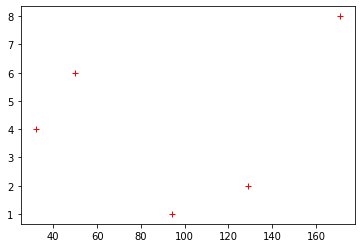

In [63]:
plt.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)

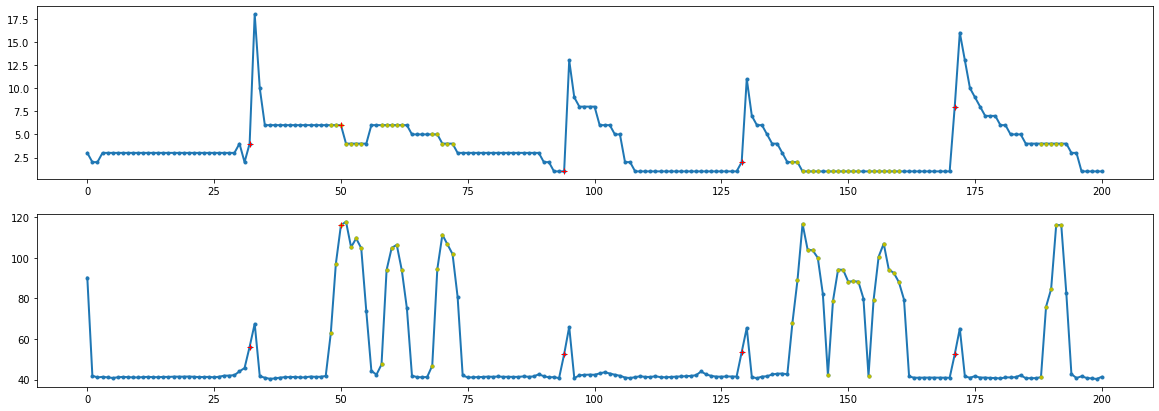

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(20, 7))
axs[0].plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs[0].plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)

axs[1].plot(data[:,0],data[:,2],'.-',label='LapTime', linewidth=2)
axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
axs[1].plot(pits[:,0],pits[:,2],'+',color='r', label='PitStop', linewidth=2)

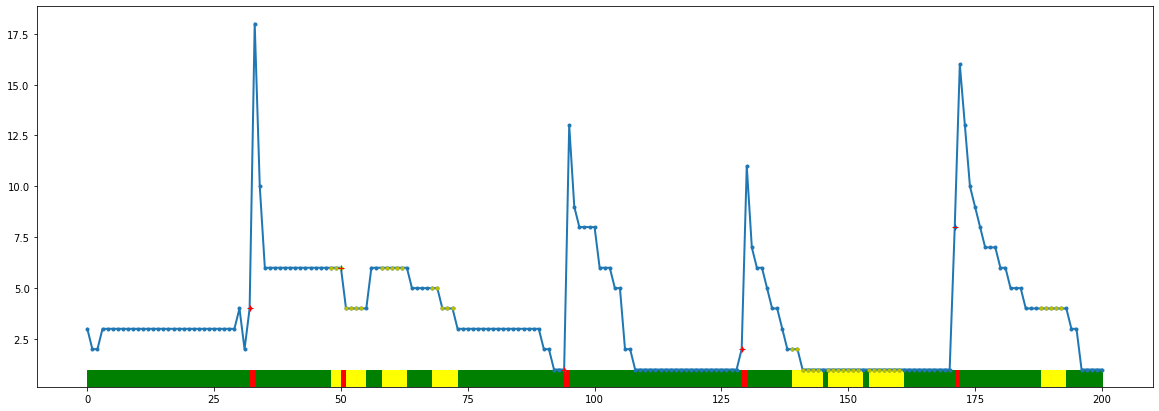

In [79]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
axs.plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
axs.plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)

for lap in range(200):
    fc = 'green'
    if caution[lap] == 1:
        fc = 'yellow'
    if pitstop[lap] == 1:
        fc = 'red'
    ec = fc
    rectangle = plt.Rectangle((lap,0), 1, 1, fc=fc,ec=ec)
    #plt.gca().add_patch(rectangle)
    axs.add_patch(rectangle)


In [ ]:
red = ''#ff8080'
yellow = '#8080ff'
green = '#80ff80'

def add_status(axs):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,-1), 1, 1, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

fig, axs = plt.subplots(2, 1, figsize=(20, 7))
axs[0].plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
#axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs[0].plot(pits[:,0],pits[:,1],'^',color='r', label='PitStop', linewidth=2)
for lap in range(200):
    fc = 'green'
    if caution[lap] == 1:
        fc = 'yellow'
    if pitstop[lap] == 1:
        fc = 'red'
    ec = fc
    rectangle = plt.Rectangle((lap,-1), 1, 1, fc=fc,ec=ec)
    #plt.gca().add_patch(rectangle)
    axs[0].add_patch(rectangle)
axs[0].set_ylim((-1,17.5))
axs[0].set_ylabel('Rank')

axs[1].plot(data[:,0],data[:,2],'.-',label='LapTime', linewidth=2)
#axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
axs[1].plot(pits[:,0],pits[:,2],'^',color='r', label='PitStop', linewidth=2)
for lap in range(200):
    fc = 'green'
    if caution[lap] == 1:
        fc = 'yellow'
    if pitstop[lap] == 1:
        fc = 'red'
    ec = fc
    rectangle = plt.Rectangle((lap,35), 1, 4, fc=fc,ec=ec)
    #plt.gca().add_patch(rectangle)
    axs[1].add_patch(rectangle)
axs[1].set_ylim((35,120))    

axs[1].set_ylabel('LapTime(s)')
axs[1].set_xlabel('Lap')

In [105]:
data = data[1:,:]
#pits = pits[1:]


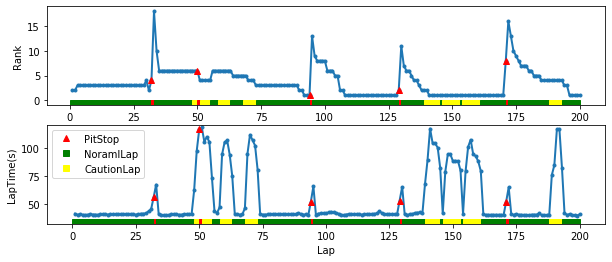

In [115]:

#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

def add_status(axs,y=-1, height=1):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
axs[0].plot(data[:,0],data[:,1],'.-', linewidth=lw)
#axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs[0].plot(pits[:,0],pits[:,1],'^',color='r', label='PitStop', linewidth=lw)
add_status(axs[0])
axs[0].set_ylim((-1,19))
axs[0].set_ylabel('Rank')

axs[1].plot(data[:,0],data[:,2],'.-', linewidth=lw)
#axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
axs[1].plot(pits[:,0],pits[:,2],'^',color='r', label='PitStop', linewidth=lw)
add_status(axs[1],33,4)
axs[1].set_ylim((33,120))    

axs[1].set_ylabel('LapTime(s)')
axs[1].set_xlabel('Lap')

axs[1].plot([0],[0],'s',color=green, label='NoramlLap', linewidth=lw)
axs[1].plot([0],[0],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('laptime_rank.pdf')

In [114]:
plt.savefig('laptime_rank.pdf')

<Figure size 432x288 with 0 Axes>

In [121]:
savedata('Fig2-b.pickle',[data, pits, caution, pitstop])

In [118]:
### check the rank
df = rankdata
df[df['completed_laps']==186]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
17214,1,64,19,186,9922.8886,41.4202,T,40.6296,B6,0.0000,...,0.0000,0,1,40.6296,Active,G,5,9D,1A,A
17251,2,25,16,186,9927.1377,40.9477,T,40.7877,6C,4.2491,...,4.2491,0,2,40.7877,Active,G,6,9D,17,0
17253,3,60,1E,186,9931.9162,42.6112,T,40.6400,25,9.0276,...,4.7785,0,3,40.6400,Active,G,5,9E,1F,0
17255,4,12,2,186,9937.2821,40.7106,T,40.3590,24,14.3935,...,5.3659,0,4,40.3590,Active,G,5,AB,3,36
17257,5,9,8,186,9939.1595,41.2391,T,40.6543,85,16.2709,...,1.8774,0,5,40.6543,Active,G,5,A0,9,0
17258,6,20,0,186,9939.7773,41.4124,T,40.2368,21,16.8887,...,0.6178,0,6,40.2368,Active,G,5,AD,1,41
17260,7,27,1F,186,9940.3390,41.2248,T,40.3275,B3,17.4504,...,0.5617,0,7,40.3275,Active,G,5,AE,20,1
17261,8,28,D,186,9940.9865,40.9859,T,40.4560,B4,18.0979,...,0.6475,0,8,40.4560,Active,G,5,AC,E,1
17263,9,22,1,186,9942.0029,40.5574,T,40.4933,B5,19.1143,...,1.0164,0,9,40.4933,Active,G,5,AF,2,1


In [119]:
rankdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5769 entries, 0 to 18498
Data columns (total 21 columns):
rank                    5769 non-null int64
car_number              5769 non-null int64
unique_id               5769 non-null object
completed_laps          5769 non-null int64
elapsed_time            5769 non-null float64
last_laptime            5769 non-null float64
lap_status              5769 non-null object
best_laptime            5769 non-null float64
best_lap                5769 non-null object
time_behind_leader      5769 non-null float64
laps_behind_leade       5769 non-null object
time_behind_prec        5769 non-null float64
laps_behind_prec        5769 non-null object
overall_rank            5769 non-null object
overall_best_laptime    5769 non-null float64
current_status          5769 non-null object
track_status            5769 non-null object
pit_stop_count          5769 non-null object
last_pitted_lap         5769 non-null object
start_position          5769 non-n

In [120]:
import pickle
def savedata(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)